## Neural Machine Translation with Attention

In [1]:
import tensorflow as tf
import re
import string
import numpy as np
from unicodedata import normalize
import tensorflow_text as tf_text
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import typing
from typing import Any, Tuple

In [2]:
path_to_file = "dataset/spa.txt"
MAX_LINES = 20000

In [3]:
embedding_dim = 200
units = 256

## Data

In [4]:
import pathlib

def load_data(path):
    text = path.read_text(encoding='utf-8')

    lines = text.splitlines()
    pairs = [line.split('\t')[:2] for line in lines]

    inp = [inp for targ, inp in pairs]
    targ = [targ for targ, inp in pairs]

    return targ, inp

In [5]:
p = pathlib.Path('')
path_to_file = p/'dataset/spa.txt'
targ, inp = load_data(path_to_file)

In [6]:
example_text = tf.constant('¿Todavía está en casa?')

####  create a tf.data dataset

In [7]:
BUFFER_SIZE = len(inp)
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((inp, targ)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)

In [8]:
for example_input_batch, example_target_batch in dataset.take(1):
    print(example_input_batch[:5])
    print()
    print(example_target_batch[:5])
    break

tf.Tensor(
[b'Toma todo el tiempo que necesites.'
 b'Puedes tomar un paraguas si necesitas uno.' b'Yo hablo conmigo mismo.'
 b'Estoy feliz de que Tom est\xc3\xa9 feliz.'
 b'\xc2\xbfPuedo pagar el libro con un cheque?'], shape=(5,), dtype=string)

tf.Tensor(
[b'Take all the time you need.'
 b'You can borrow an umbrella if you need one.' b'I talk to myself.'
 b"I'm happy that Tom is happy." b'Can I pay for the book by check?'], shape=(5,), dtype=string)


#### Text Processing

In [9]:
def tf_lower_and_split_punct(text):
    # Split accecented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Keep space, a to z, and select punctuation.
    text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
    # Add spaces around punctuation.
    text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

#### Text Vectorization

In [10]:
max_vocab_size = 5000

input_text_processor = preprocessing.TextVectorization(standardize=tf_lower_and_split_punct, 
                                                       max_tokens=max_vocab_size)
input_text_processor.adapt(inp)

In [11]:
output_text_processor = preprocessing.TextVectorization(standardize=tf_lower_and_split_punct, 
                                                       max_tokens=max_vocab_size)
output_text_processor.adapt(targ)

In [12]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,  705,   57,    7,   60,    5, 2960,    4,    3,    0],
       [   2,  101,  314,   16,  808,   44,  420,  179,    4,    3],
       [   2,   39,  504,  223,  161,    4,    3,    0,    0,    0]],
      dtype=int64)>

In [13]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] toma todo el tiempo que necesites . [END]           '

Text(0.5, 1.0, 'Mask')

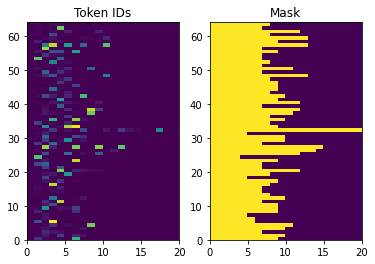

In [14]:
import matplotlib.pyplot as plt


plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')


plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

### Encoder

In [15]:
class Encoder(keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size
        self.embedding = Embedding(self.input_vocab_size, embedding_dim)
        self.gru = GRU(self.enc_units,
                      return_sequences=True,
                      return_state=True,
                      recurrent_initializer='glorot_uniform')
            
    def call(self, tokens, state=None):
        vectors = self.embedding(tokens)
        output, state = self.gru(vectors, initial_state=state)
        return output, state

In [16]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, 
                  units)

example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')


Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 20)
Encoder output, shape (batch, s, units): (64, 20, 256)
Encoder state, shape (batch, units): (64, 256)


### Attention

In [17]:
class BahdanauAttention(keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = Dense(units, use_bias=False)
        self.W2 = Dense(units, use_bias=False)
        self.attention = AdditiveAttention()
        
    def call(self, query, value, mask):
        w1_query = self.W1(query)
        w2_key = self.W2(value)
        
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask
    
        context_vector, attention_weights = self.attention(inputs=[w1_query, w2_key],
                                                           mask=[query_mask, value_mask],
                                                           return_attention_scores =True)
        return context_vector, attention_weights
           

In [18]:
attention_layer = BahdanauAttention(units)

example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 20])
context_vector, attention_weights = attention_layer(query=example_attention_query,
                                                    value=example_enc_output,
                                                    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units): {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

print(example_attention_query.shape)
print(example_enc_output.shape)
print(context_vector.shape)

Attention result shape: (batch_size, query_seq_length, units): (64, 2, 256)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 20)
(64, 2, 20)
(64, 20, 256)
(64, 2, 256)


Text(0.5, 1.0, 'Mask')

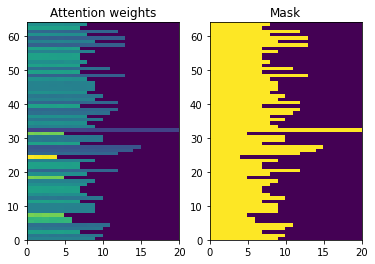

In [19]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

### Decoder

In [20]:
class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any

class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any

In [21]:
class Decoder(keras.layers.Layer):
    def __init__(self, target_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.target_vocab_size = target_vocab_size
        self.embedding_dim = embedding_dim
        self.embedding = Embedding(self.target_vocab_size, 
                                   embedding_dim)
        self.gru = GRU(self.dec_units,
                      return_sequences=True,
                      return_state=True,
                      recurrent_initializer='glorot_uniform')
        self.attention = BahdanauAttention(self.dec_units)
        #  converting context vector to attention vector
        self.Wc = Dense(dec_units,
                       activation=tf.math.tanh,
                       use_bias=False)
        # producing logits
        self.fc = Dense(self.target_vocab_size)
        
    def call(self, 
             inputs:DecoderInput, 
             state=None) -> Tuple[DecoderOutput, tf.Tensor]:
        vectors = self.embedding(inputs.new_tokens)
        rnn_output, state = self.gru(vectors, initial_state=state)
        context_vector, attention_weights = self.attention(query=rnn_output,
                                                          value=inputs.enc_output,
                                                          mask=inputs.mask)
        context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)
        attention_vector = self.Wc(context_and_rnn_output)
        logits = self.fc(attention_vector)
        
        return DecoderOutput(logits, attention_weights), state
        

In [22]:
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [23]:
example_output_tokens = output_text_processor(example_target_batch)
start_index = output_text_processor._index_lookup_layer('[START]').numpy()
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

dec_result, dec_state = decoder(inputs = DecoderInput(new_tokens=first_token, 
                                                      enc_output=example_enc_output,
                                                      mask=(example_tokens != 0)),
                                state = example_enc_state)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 256)


### Training

In [24]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
                from_logits=True, reduction='none')
        
    def __call__(self, y_true, y_pred):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask
        return tf.reduce_sum(loss)

#### Implementing the training step

In [25]:
class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
                input_text_processor,
                output_text_processor,
                use_tf_function=True):
        super().__init__()
        
        encoder = Encoder(input_text_processor.vocabulary_size(),
                         embedding_dim, 
                         units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                         embedding_dim,
                         units)
        
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function
        
    def train_step(self, inputs):
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_steps(inputs)
        
    def _preprocess(self, input_text, target_text):
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)
        
        input_mask = input_tokens != 0
        target_mask = target_tokens != 0
        
        return input_tokens, input_mask, target_tokens, target_mask
    
    def _train_steps(self, inputs):
        input_text, target_text = inputs
        
        (input_tokens, input_mask,
         target_tokens, target_mask) = self._preprocess(input_text, target_text)
        
        max_target_length = tf.shape(target_tokens)[1]
        
        with tf.GradientTape() as tape:
            enc_output, enc_state = self.encoder(input_tokens)
            dec_state = enc_state
            loss = tf.constant(0.0)
            
        for t in tf.range(max_target_length-1):
            new_tokens = target_tokens[:, t:t+2]
            step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
            loss = loss + step_loss
            
        average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))
            
        variables = self.trainable_variables 
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        
        return {'batch_loss': average_loss}
    
    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

        # Run the decoder one step.
        decoder_input = DecoderInput(new_tokens=input_token,
                                   enc_output=enc_output,
                                   mask=input_mask)

        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

        # `self.loss` returns the total for non-padded tokens
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)

        return step_loss, dec_state
            

In [26]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)

# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [27]:
for n in range(10):
    print(translator.train_step([example_input_batch, example_target_batch]))
print()

ValueError: No gradients provided for any variable: ['encoder_1/embedding_2/embeddings:0', 'encoder_1/gru_2/gru_cell_2/kernel:0', 'encoder_1/gru_2/gru_cell_2/recurrent_kernel:0', 'encoder_1/gru_2/gru_cell_2/bias:0', 'decoder_1/embedding_3/embeddings:0', 'decoder_1/gru_3/gru_cell_3/kernel:0', 'decoder_1/gru_3/gru_cell_3/recurrent_kernel:0', 'decoder_1/gru_3/gru_cell_3/bias:0', 'decoder_1/bahdanau_attention_2/dense_6/kernel:0', 'decoder_1/bahdanau_attention_2/dense_7/kernel:0', 'decoder_1/bahdanau_attention_2/additive_attention_2/scale:0', 'decoder_1/dense_8/kernel:0', 'decoder_1/dense_9/kernel:0', 'decoder_1/dense_9/bias:0'].